In [1]:
from collections import Counter
import openpyxl
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import openpyxl
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import math
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import (accuracy_score, f1_score,average_precision_score, confusion_matrix,
                             average_precision_score, precision_score, recall_score, roc_auc_score)
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeClassifier 
from numpy import where
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def read_excel(filename, nrows):
    book = openpyxl.load_workbook(filename=filename, read_only=False, data_only=True)
    first_sheet = book.worksheets[0]
    rows_generator = first_sheet.values

    header_row = next(rows_generator)
    data_rows = [row for (_, row) in zip(range(nrows - 1), rows_generator)]
    return pd.DataFrame(data_rows, columns=header_row)


churn_dataset = read_excel(r"/content/drive/MyDrive/turknetchurnekimanonim.xlsx", 192293)

In [4]:
len(churn_dataset)

192292

In [5]:
# açıklama sütunundaki integer değeri çekme
churn_dataset["ACIKLAMA"]
i =0
integer = []

for row in churn_dataset['ACIKLAMA']:
    parcalar = row.split(" ")
    if parcalar[1] == "İletişim)" or parcalar[1] == "İletişim)(Yapa)":
        integer.append(parcalar[2])
    elif parcalar[1] == "Fiber)":
        integer.append(parcalar[2])
    else:
        integer.append(parcalar[1])
churn_dataset['ACIKLAMA']=integer
churn_dataset['ACIKLAMA'] =churn_dataset['ACIKLAMA'].astype(int)
churn_dataset['ACIKLAMA']

0         100
1         100
2          16
3          35
4         100
         ... 
192287     35
192288     35
192289     35
192290    100
192291     35
Name: ACIKLAMA, Length: 192292, dtype: int64

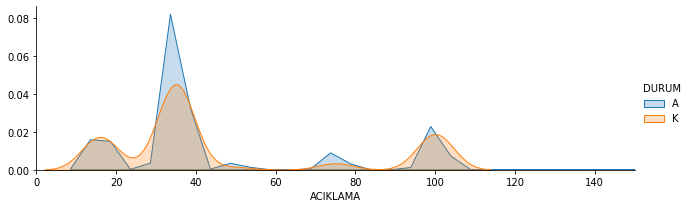

In [6]:
facet = sns.FacetGrid(churn_dataset, hue="DURUM",aspect=3)
facet.map(sns.kdeplot,"ACIKLAMA",shade= True)
facet.set(xlim=(0, 150))
facet.add_legend()

plt.show()

In [7]:
# tahmin edilecek sutündaki null değerleri çıkarma
churn_dataset = churn_dataset.dropna(subset = ['DURUM'])
len(churn_dataset)

192292

In [8]:
Counter(churn_dataset['DURUM'])

#'CINSIYET','ODEMESEKLI', 'YAPA_VAE','FATURAGONDERIMTIPI' string columns encoding
labelEncoder = LabelEncoder()
#y = labelEncoder.fit_transform()

churn_dataset[['CINSIYET','ODEMESEKLI', 'YAPA_VAE','FATURAGONDERIMTIPI','DURUM']] =churn_dataset[['CINSIYET','ODEMESEKLI', 'YAPA_VAE','FATURAGONDERIMTIPI','DURUM']].apply(LabelEncoder().fit_transform)
churn_dataset[['CINSIYET','ODEMESEKLI', 'YAPA_VAE','FATURAGONDERIMTIPI','DURUM']]

#drop duplicate columns
churn_dataset = churn_dataset.T.drop_duplicates().T


# Remove Nan column
churn_dataset = churn_dataset[set(list(churn_dataset)) - set([None])]


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


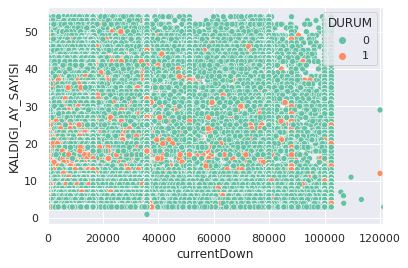

In [9]:
a=[]
sns.set(palette="Set2")
ax =sns.scatterplot(x = "currentDown", y = "KALDIGI_AY_SAYISI",data =churn_dataset,  hue="DURUM")
ax.set_xlim([0, 120900])
ax

In [10]:
#drop duplicate columns
churn_dataset = churn_dataset.T.drop_duplicates().T
churn_dataset

,INTERNETEBAGLANAMIYORUM_TICKETSL_3,INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_1,FATURAINCELEME_DESTEKSAYISI_2,TOTALDOWNLOADGB_3,TOTALDOWNLOADGB_1,RISKLIMUSTERI,TOTALUPLOADGB_1,FATURAINCELEME_DESTEKSAYISI_1,IKNATICKET_1,TOTALUPLOADGB_2,FATURA_GECIKME_UCRETI_2,CM_DESTEKSAYISI_3,TDU_TICKETSL_3,CHURNTEST_DATE,ODEMESEKLI,CM_DESTEKSAYISI_1,currentDown,ILTELKODU,PORTERROR_SAYISI_2,CM_TICKETKAPANMASURESI_1,CINSIYET,TDU_DESTEKSAYISI_1,CM_TICKETSL_3,INTERNETEBAGLANAMIYORUM_DESTEKSAYISI_3,ARKADASINIGETIR,TOTALUPLOADGB_3,TDU_DESTEKSAYISI_2,DURUM,ADSLARIZA_DESTEKSAYISI_1,OIMSIKAYET_DESTEKSAYISI_3,ADSLARIZA_DESTEKSAYISI_3,INTERNETEBAGLANAMIYORUM_DESTEKSAYISI_2,FATURA_GECIKME_2,ADSLARIZA_DESTEKSAYISI_2,INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_2,KALDIGI_AY_SAYISI,DENVERGIRISTARIHI_1,INTERNETEBAGLANAMIYORUM_TICKETSL_1,OIMSIKAYET_DESTEKSAYISI_1,CM_TICKETSL_2,...,ABONEBAS,ACIKLAMA,MIN_SESSIONTIME_3,ADSLARIZA_TICKETKAPANMASURESI_3,IKNATICKET_2,CM_TICKETSL_1,KAPASITE,FATURAINCELEME_DESTEKKAPANMASURESI_1,ARKADASINIGETIRILEGELENLER,FATURA_GECIKME_1,MAX_SESSIONTIME_2,ADSLARIZA_TICKETKAPANMASURESI_1,DESTEKSAYISI_2,ILADI,CLOSE_DATE,FATURAGONDERIMTIPI,TDU_TICKETSL_1,DESTEKSAYISI_3,PORTERROR_SAYISI_1,HIZMETKANALI_SIKAYETSAYISI_1,INTERNETEBAGLANAMIYORUM_TICKETSL_2,FATURA_GECIKME_UCRETI_3,ADSLARIZA_TICKETKAPANMASURESI_2,TDU_TICKETKAPANMASURESI_3,ADSLARIZA_TICKETSL_2,ADSLARIZA_TICKETSL_1,DESTEKSAYISI_1,MAX_SESSIONTIME_1,PORTERROR_SAYISI_3,FATURA_GECIKME_UCRETI_1,TOTALDOWNLOADGB_2,IKNATICKET_3,ADSLARIZA_TICKETSL_3,OIMSIKAYET_DESTEKSAYISI_2,CM_TICKETKAPANMASURESI_2,YAPA_VAE,MIN_SESSIONTIME_1,CAGRIMERKEZIARAMASAYISI_1,CM_TICKETKAPANMASURESI_3,TDU_TICKETKAPANMASURESI_1
0,0,0,0,272.197,184.717,0,8.3357,0,0,11.5741,0,0,0,2020-10-31,1,0,7774,212,7,0,0,0,0,0,NaN,16.5013,0,0,0,0,0,0,0,0,0,54,None,0,0,0,...,2016-04-20,100,0,0,0,0,102400,0,0,0,93144,0,0,İstanbul (Avrupa),NaT,0,0,0,1,0,0,0,0,0,0,0,0,188997,10,0,227.03,0,0,0,0,1,0,0,0,0
1,0,0,0,185.583,388.755,0,101.539,0,0,33.2407,0,0,0,2020-10-31,1,0,NaN,212,12,0,1,0,0,0,NaN,135.866,0,0,0,0,0,0,0,0,0,54,None,0,0,0,...,2016-04-20,100,0,0,0,0,102400,0,0,0,89565,0,0,İstanbul (Avrupa),NaT,0,0,0,5,0,0,0,0,0,0,0,0,174467,1,0,118.329,0,0,0,0,0,0,0,0,0
2,0,0,0,46.6458,54.2985,0,2.2413,0,0,2.3205,0,0,0,2020-10-31,1,0,16381,262,0,0,0,0,0,0,NaN,1.8255,0,0,0,0,0,0,0,0,0,54,None,0,0,0,...,2016-04-21,16,0,0,0,0,16384,0,0,0,93840,0,0,Kocaeli,NaT,0,0,0,6,0,0,0,0,0,0,0,0,87347,3,0,54.1644,0,0,0,0,0,0,0,0,0
3,0,0,0,42.0181,64.473,0,3.8624,0,0,11.6085,0,0,0,2020-10-31,0,0,35839,212,7,0,0,0,0,0,3,2.0288,0,0,0,0,0,0,0,0,0,54,None,0,0,0,...,2016-04-21,35,1664,0,0,0,35840,0,0,0,93579,0,0,İstanbul (Avrupa),NaT,0,0,0,2,0,0,0,0,0,0,0,0,276105,15,0,116.422,0,0,0,0,0,1777,0,0,0
4,0,0,0,0,0,0,0,0,2,0,0,0,0,2020-10-31,1,0,10535,212,0,0,0,0,0,0,4,0,6,0,0,2,2,0,0,6,0,54,None,0,2,0,...,2016-04-21,100,0,4668,0,0,102400,0,0,0,0,0,6,İstanbul (Avrupa),2020-10-02,0,0,6,0,0,0,0,14721,4668,1,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192287,0,0,0,858.641,2499.38,0,127.619,0,0,94.0199,0,0,0,2020-10-31,0,0,35839,212,4,0,0,0,0,0,NaN,39.4116,0,1,0,0,4,0,0,0,0,3,None,0,0,0,...,2020-07-17,35,0,1365,0,0,35840,0,1,2,375161,0,0,İstanbul (Avrupa),2020-10-26,0,0,16,0,0,0,0,0,1365,0,0,0,493788,0,1.1,1822.92,0,0,0,0,0,14469,0,0,0
192288,0,0,0,71.4414,102.215,0,12.5308,0,0,10.7205,0,0,0,2020-10-31,0,0,35840,212,17,0,1,0,0,0,NaN,6.8417,3,0,0,0,1,0,0,3,0,3,None,0,1,0,...,2020-07-17,35,0,1498,0,0,35840,0,1,0,90590,0,3,İstanbul (Avrupa),NaT,0,0,7,4,0,0,0,3637,1498,0,0,1,101968,5,0,123.277,0,0,0,0,0,0,0,0,0
192289,0,0,0,256.38,1510.7,0,101.924,0,0,81.7638,0,0,0,2020-10-31,0,0,35836,312,8,0,0,2,0,0,NaN,24.6878,0,0,2,0,0,0,0,0,0,3,None,0,0,0,...,2020-07-17,35,2125

In [11]:
# Remove NaN column
churn_dataset = churn_dataset[set(list(churn_dataset)) - set([None])]
churn_dataset

,INTERNETEBAGLANAMIYORUM_TICKETSL_3,INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_1,FATURAINCELEME_DESTEKSAYISI_2,TOTALDOWNLOADGB_3,TOTALDOWNLOADGB_1,RISKLIMUSTERI,TOTALUPLOADGB_1,FATURAINCELEME_DESTEKSAYISI_1,IKNATICKET_1,TOTALUPLOADGB_2,TDU_TICKETSL_3,FATURA_GECIKME_UCRETI_2,CM_DESTEKSAYISI_3,CHURNTEST_DATE,ODEMESEKLI,CM_DESTEKSAYISI_1,currentDown,ILTELKODU,TDU_TICKETKAPANMASURESI_1,PORTERROR_SAYISI_2,CM_TICKETKAPANMASURESI_1,CINSIYET,TDU_DESTEKSAYISI_1,CM_TICKETSL_3,INTERNETEBAGLANAMIYORUM_DESTEKSAYISI_3,ARKADASINIGETIR,TOTALUPLOADGB_3,TDU_DESTEKSAYISI_2,DURUM,ADSLARIZA_DESTEKSAYISI_1,OIMSIKAYET_DESTEKSAYISI_3,ADSLARIZA_DESTEKSAYISI_3,INTERNETEBAGLANAMIYORUM_DESTEKSAYISI_2,FATURA_GECIKME_2,ADSLARIZA_DESTEKSAYISI_2,INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_2,KALDIGI_AY_SAYISI,DENVERGIRISTARIHI_1,INTERNETEBAGLANAMIYORUM_TICKETSL_1,OIMSIKAYET_DESTEKSAYISI_1,...,CAGRIMERKEZIARAMASAYISI_2,ABONEBAS,ACIKLAMA,MIN_SESSIONTIME_3,ADSLARIZA_TICKETKAPANMASURESI_3,IKNATICKET_2,KAPASITE,FATURAINCELEME_DESTEKKAPANMASURESI_1,ARKADASINIGETIRILEGELENLER,FATURA_GECIKME_1,MAX_SESSIONTIME_2,ADSLARIZA_TICKETKAPANMASURESI_1,DESTEKSAYISI_2,ILADI,CLOSE_DATE,FATURAGONDERIMTIPI,TDU_TICKETSL_1,DESTEKSAYISI_3,PORTERROR_SAYISI_1,HIZMETKANALI_SIKAYETSAYISI_1,INTERNETEBAGLANAMIYORUM_TICKETSL_2,FATURA_GECIKME_UCRETI_3,ADSLARIZA_TICKETKAPANMASURESI_2,TDU_TICKETKAPANMASURESI_3,ADSLARIZA_TICKETSL_2,ADSLARIZA_TICKETSL_1,DESTEKSAYISI_1,MAX_SESSIONTIME_1,PORTERROR_SAYISI_3,FATURA_GECIKME_UCRETI_1,TOTALDOWNLOADGB_2,IKNATICKET_3,ADSLARIZA_TICKETSL_3,OIMSIKAYET_DESTEKSAYISI_2,CM_TICKETKAPANMASURESI_2,YAPA_VAE,MIN_SESSIONTIME_1,CAGRIMERKEZIARAMASAYISI_1,CM_TICKETKAPANMASURESI_3,CM_TICKETSL_1
0,0,0,0,272.197,184.717,0,8.3357,0,0,11.5741,0,0,0,2020-10-31,1,0,7774,212,0,7,0,0,0,0,0,NaN,16.5013,0,0,0,0,0,0,0,0,0,54,None,0,0,...,0,2016-04-20,100,0,0,0,102400,0,0,0,93144,0,0,İstanbul (Avrupa),NaT,0,0,0,1,0,0,0,0,0,0,0,0,188997,10,0,227.03,0,0,0,0,1,0,0,0,0
1,0,0,0,185.583,388.755,0,101.539,0,0,33.2407,0,0,0,2020-10-31,1,0,NaN,212,0,12,0,1,0,0,0,NaN,135.866,0,0,0,0,0,0,0,0,0,54,None,0,0,...,0,2016-04-20,100,0,0,0,102400,0,0,0,89565,0,0,İstanbul (Avrupa),NaT,0,0,0,5,0,0,0,0,0,0,0,0,174467,1,0,118.329,0,0,0,0,0,0,0,0,0
2,0,0,0,46.6458,54.2985,0,2.2413,0,0,2.3205,0,0,0,2020-10-31,1,0,16381,262,0,0,0,0,0,0,0,NaN,1.8255,0,0,0,0,0,0,0,0,0,54,None,0,0,...,0,2016-04-21,16,0,0,0,16384,0,0,0,93840,0,0,Kocaeli,NaT,0,0,0,6,0,0,0,0,0,0,0,0,87347,3,0,54.1644,0,0,0,0,0,0,0,0,0
3,0,0,0,42.0181,64.473,0,3.8624,0,0,11.6085,0,0,0,2020-10-31,0,0,35839,212,0,7,0,0,0,0,0,3,2.0288,0,0,0,0,0,0,0,0,0,54,None,0,0,...,0,2016-04-21,35,1664,0,0,35840,0,0,0,93579,0,0,İstanbul (Avrupa),NaT,0,0,0,2,0,0,0,0,0,0,0,0,276105,15,0,116.422,0,0,0,0,0,1777,0,0,0
4,0,0,0,0,0,0,0,0,2,0,0,0,0,2020-10-31,1,0,10535,212,0,0,0,0,0,0,0,4,0,6,0,0,2,2,0,0,6,0,54,None,0,2,...,0,2016-04-21,100,0,4668,0,102400,0,0,0,0,0,6,İstanbul (Avrupa),2020-10-02,0,0,6,0,0,0,0,14721,4668,1,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192287,0,0,0,858.641,2499.38,0,127.619,0,0,94.0199,0,0,0,2020-10-31,0,0,35839,212,0,4,0,0,0,0,0,NaN,39.4116,0,1,0,0,4,0,0,0,0,3,None,0,0,...,0,2020-07-17,35,0,1365,0,35840,0,1,2,375161,0,0,İstanbul (Avrupa),2020-10-26,0,0,16,0,0,0,0,0,1365,0,0,0,493788,0,1.1,1822.92,0,0,0,0,0,14469,0,0,0
192288,0,0,0,71.4414,102.215,0,12.5308,0,0,10.7205,0,0,0,2020-10-31,0,0,35840,212,0,17,0,1,0,0,0,NaN,6.8417,3,0,0,0,1,0,0,3,0,3,None,0,1,...,0,2020-07-17,35,0,1498,0,35840,0,1,0,90590,0,3,İstanbul (Avrupa),NaT,0,0,7,4,0,0,0,3637,1498,0,0,1,101968,5,0,123.277,0,0,0,0,0,0,0,0,0
192289,0,0,0,256.38,1510.7,0,101.924,0,0,81.7638,0,0,0,2020-10-31,0,0,35836,312,3,8,0,0,2,0,0,NaN,24.6878,0,0,2,0,0,0,0,0,0,3,None,0,0,...,0,2020

In [12]:
#Remove empty or useless columns
churn_dataset=churn_dataset.drop(['MAX_SESSIONTIME_2','ABONEBAS','TOTALDOWNLOADGB_1','MIN_SESSIONTIME_2','CM_TICKETKAPANMASURESI_3','CM_TICKETKAPANMASURESI_1','INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_1','TOTALDOWNLOADGB_2','CM_TICKETKAPANMASURESI_2','MIN_SESSIONTIME_3','PORTERROR_SAYISI_1','ILTELKODU','ADSLARIZA_TICKETKAPANMASURESI_2','ADSLARIZA_TICKETKAPANMASURESI_3','POSILCE','TDU_TICKETKAPANMASURESI_1','MAX_SESSIONTIME_1','TDU_TICKETKAPANMASURESI_3','MIN_SESSIONTIME_1','TOTALUPLOADGB_2','CLOSE_DATE','PORTERROR_SAYISI_2','PORTERROR_SAYISI_3','TDU_TICKETKAPANMASURESI_2','ILCE','INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_3','TOTALUPLOADGB_3','CHURNTEST_DATE','ADSLARIZA_TICKETKAPANMASURESI_1','TOTALUPLOADGB_1','MAX_SESSIONTIME_3','INTERNETEBAGLANAMIYORUM_TICKETKAPANMASURESI_2','ILADI','TOTALDOWNLOADGB_3'],axis =1)

churn_dataset = churn_dataset[set(list(churn_dataset))-set(['DENVERGIRISTARIHI_3'])-set(['DENVERGIRISTARIHI_1'])]

list(churn_dataset)

Counter(churn_dataset['DURUM'])

churn_dataset['ARKADASINIGETIR'] =churn_dataset['ARKADASINIGETIR'].fillna(0) #sadece bu sütunda NaN değer var
churn_dataset['currentDown'] =churn_dataset['currentDown'].fillna(0)
churn_dataset['ARKADASINIGETIR'] =churn_dataset['ARKADASINIGETIR'].astype(int)
churn_dataset['currentDown'] =churn_dataset['currentDown'].astype(int)
Counter(churn_dataset['ARKADASINIGETIR'])

Counter({0: 135433,
         1: 30245,
         2: 14671,
         3: 4077,
         4: 3734,
         5: 972,
         6: 1085,
         7: 363,
         8: 531,
         9: 136,
         10: 215,
         11: 66,
         12: 131,
         13: 38,
         14: 78,
         15: 30,
         16: 29,
         17: 25,
         18: 22,
         19: 9,
         20: 26,
         21: 9,
         22: 19,
         23: 14,
         24: 18,
         25: 17,
         26: 15,
         27: 22,
         28: 11,
         29: 12,
         30: 7,
         31: 5,
         32: 12,
         33: 5,
         34: 13,
         35: 4,
         36: 8,
         37: 4,
         38: 8,
         39: 3,
         40: 3,
         41: 5,
         42: 4,
         43: 3,
         44: 7,
         45: 3,
         46: 3,
         47: 4,
         48: 2,
         49: 2,
         50: 2,
         51: 2,
         52: 5,
         53: 2,
         54: 3,
         55: 2,
         56: 7,
         58: 1,
         59: 1,
         60: 6

In [13]:
train_columns = list(set(list(churn_dataset))-set(['DURUM']))  #durum dışındaki bütün sütunlar
looked_column = list(set(['DURUM']))                           #tahmin edilecek

y = churn_dataset[looked_column]
X = churn_dataset[train_columns].astype(float)
y = churn_dataset[looked_column].astype(float)


In [17]:
cols = list(train_columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series((model.pvalues.values[1:].tolist()))
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    # print(feature_with_p_max)
    # print(pmax)
    if (pmax > 0.05):
        cols.remove(cols[feature_with_p_max])
    else:
        break

selected_features = cols

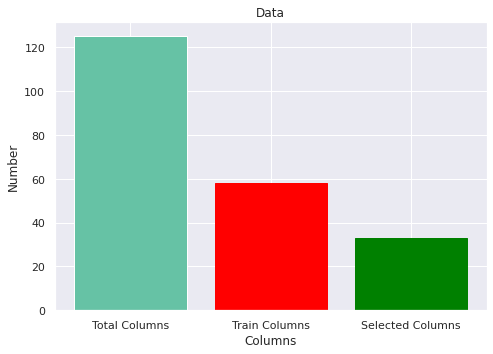

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["Total Columns", "Train Columns", "Selected Columns"]
students = [125, len(train_columns), len(selected_features)]
barlist=ax.bar(langs,students)
barlist[1].set_color('r')
barlist[2].set_color('g')
ax.set_ylabel('Number')
ax.set_xlabel('Columns')
ax.set_title('Data')
plt.savefig('/content/drive/MyDrive/history_graph/imbalanced.pdf')
plt.show()

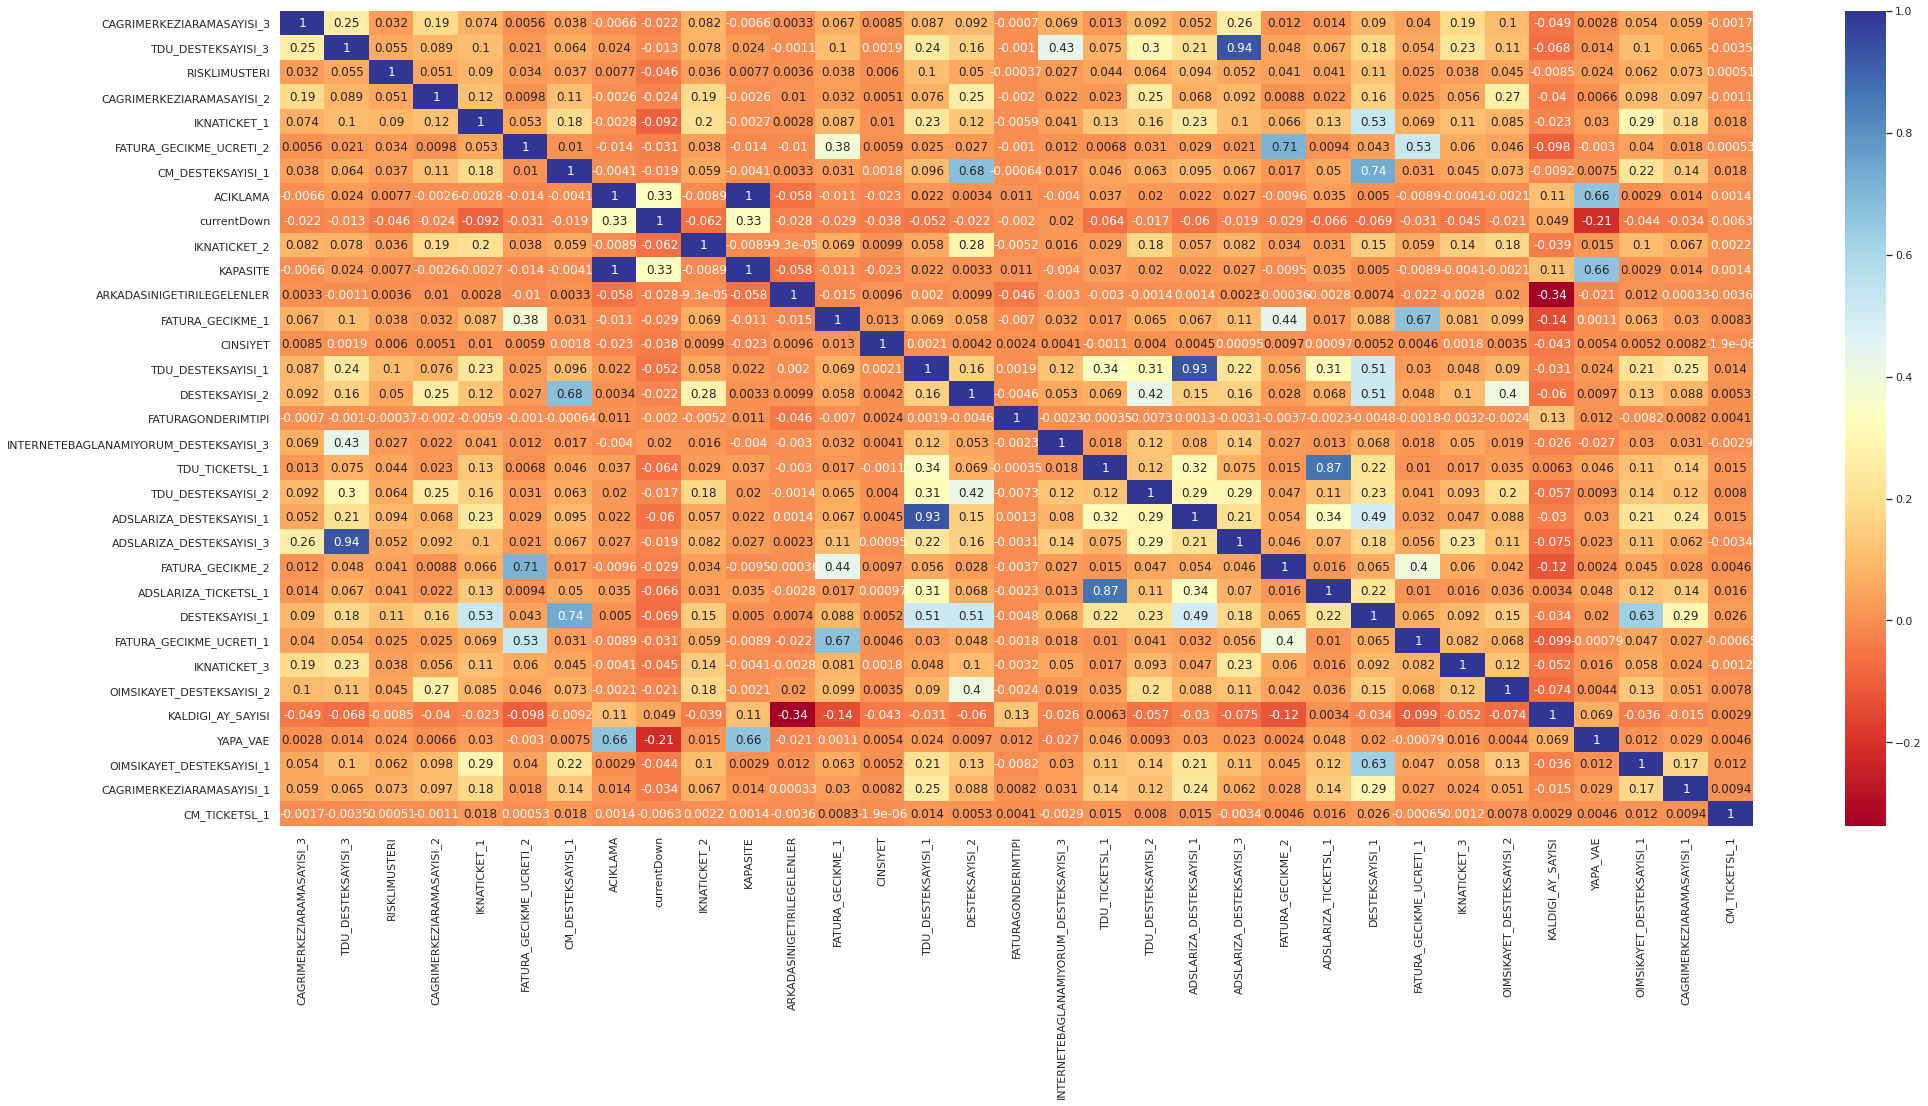

In [19]:
df = churn_dataset[selected_features].astype(float)
sns.set(palette="Set2")
plt.subplots(figsize=(33,15))
sns.heatmap(df.corr(), annot=True, cmap="RdYlBu")
plt.savefig('/content/drive/MyDrive/history_graph/corr.pdf')
plt.show()


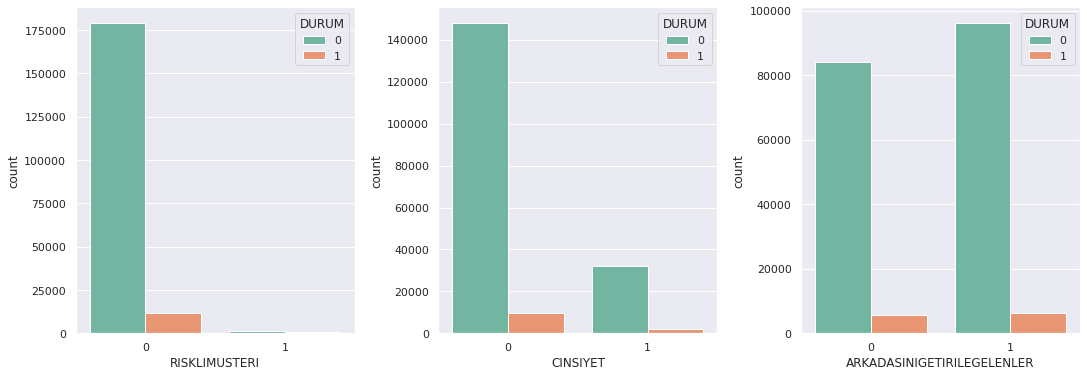

In [20]:
_, ax = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)
sns.countplot(x = "RISKLIMUSTERI", hue="DURUM", data =churn_dataset, ax= ax[0])
sns.countplot(x = "CINSIYET", hue="DURUM", data = churn_dataset, ax = ax[1])
sns.countplot(x = "ARKADASINIGETIRILEGELENLER", hue="DURUM", data = churn_dataset, ax = ax[2])

In [31]:
counter = Counter(y)
X = churn_dataset[selected_features].astype(float)
y = churn_dataset[looked_column].astype(int)
print("Before oversampling  = ", Counter(y["DURUM"]))






Before oversampling  =  Counter({0: 180339, 1: 11953})


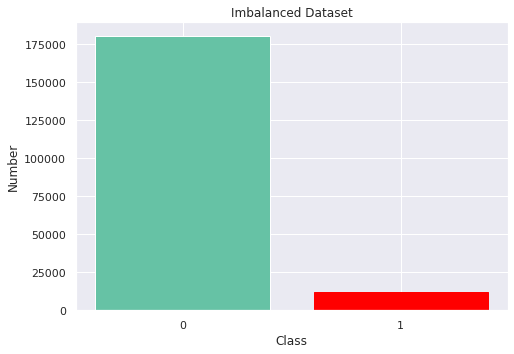

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ["0", "1"]
data = [Counter(y["DURUM"])[0], Counter(y["DURUM"])[1]]
barlist=ax.bar(classes,data)
barlist[1].set_color('r')
ax.set_ylabel('Number')
ax.set_xlabel('Class')
ax.set_title('Imbalanced Dataset')
plt.savefig('/content/drive/MyDrive/history_graph/imbalanced.pdf')
plt.show()

In [33]:
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)
print("After oversampling  = ", Counter(y))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After oversampling  =  Counter({0: 180339, 1: 180339})


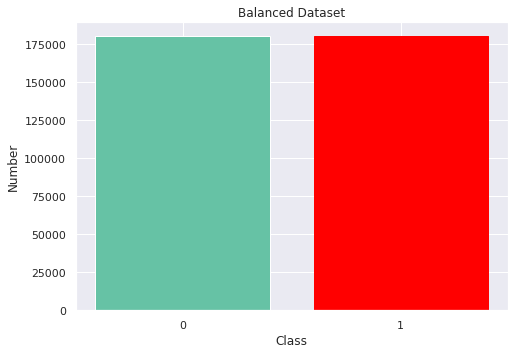

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classes = ["0", "1"]
data = [Counter(y)[0], Counter(y)[1]]
barlist=ax.bar(classes,data)
barlist[1].set_color('r')
ax.set_ylabel('Number')
ax.set_xlabel('Class')
ax.set_title('Balanced Dataset')
plt.savefig('/content/drive/MyDrive/history_graph/balanced.pdf')
plt.show()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

In [36]:
classifier = RandomForestClassifier(n_estimators = 400)
y_train = np.ravel(y_train)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

Accuracy: 0.9293667516912498
Precision: 0.9397400820793433
Recall: 0.9170949869835124
F1: 0.9282794500185805
Area under precision (AUC) Recall: 0.9031528657750676
[[42584  2643]
 [ 3726 41217]]


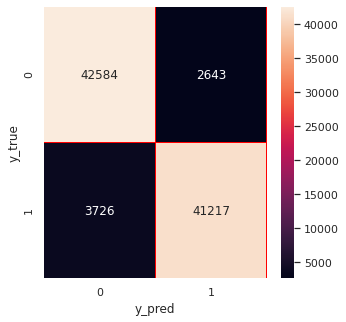

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('/content/drive/MyDrive/history_graph/random_forest_cm.pdf')
plt.show()

Accuracy: 0.9075745813463458
Precision: 0.9141570694843542
Recall: 0.8989831564426051
F1: 0.9065066188018848
Area under precision (AUC) Recall: 0.8721611479446666
[[41433  3794]
 [ 4540 40403]]


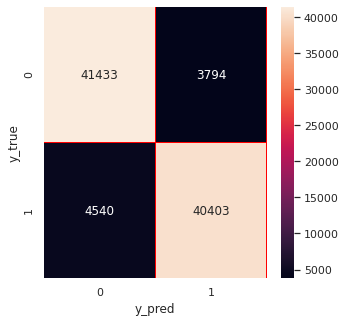

In [38]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

#predicting the test results
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('/content/drive/MyDrive/history_graph/knn_cm.pdf')
plt.show()




Accuracy: 0.9159809249195964
Precision: 0.925485641411036
Recall: 0.904234252275104
F1: 0.9147365340896301
Area under precision (AUC) Recall: 0.8845878786139595
[[41955  3272]
 [ 4304 40639]]


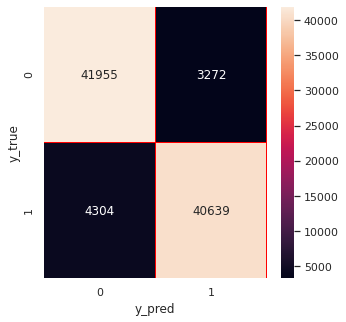

In [39]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)

#predicting the test results
y_pred = classifier.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('/content/drive/MyDrive/history_graph/decision_tree_cm.pdf')
plt.show()


Accuracy: 0.9371409559720528
Precision: 0.9626139602817498
Recall: 0.9091960928286941
F1: 0.9351428048333943
Area under precision (AUC) Recall: 0.9204638068971657
[[43640  1587]
 [ 4081 40862]]


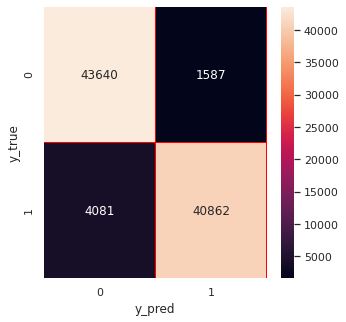

In [40]:
clf = XGBClassifier(max_depth = 12,random_state=7, n_estimators=400,
                    eval_metric = 'auc', 
                    min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.8)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Area under precision (AUC) Recall:", average_precision_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.savefig('/content/drive/MyDrive/history_graph/xgb_cm.pdf')
plt.show()